# Conversation Generator
According the NPC background to generate unique conversation.

In [18]:
import csv
from io import StringIO
import requests


def get_google_spreadsheet(spreadsheet_id):
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv"
    response = requests.get(url, timeout=10)
    if response.status_code == 200:
        csv_str = response.content.decode("utf-8")
        f = StringIO(csv_str)
        spreadsheet_data = []
        reader = csv.reader(f, delimiter=",")
        next(reader, None)  # Skip the header row
        for row in reader:
            if len(row) < 4:
                continue
            name, age, gender, background = row[:4]
            if not name:
                continue
            spreadsheet_data.append(
                {"name": name, "age": age, "gender": gender, "background": background}
            )
        return spreadsheet_data
    return None

In [ ]:
from pydantic import BaseModel

class Character(BaseModel):
    name: str
    age: int
    gender: str 
    background: str

npcs = get_google_spreadsheet("1VdQsc9qslvd-gGhydN5dEZEX6Q5uliBQqRguJyHBZM4")
main_character = npcs[0]
if main_character['name'] != 'main_character':
    raise ValueError("The main character's name is not 'main_character'")
main_character = Character(**main_character)

npcs = npcs[1:]
npcs.sort(key=lambda npc: npc['name'])
npcs = [Character(**npc) for npc in npcs]


In [20]:
npcs

[Character(name='AI', age=33, gender='Male', background='Al is a seasoned knight who has earned countless honors in Kubernetes battles. He seeks a trustworthy team to join him in fighting dark forces.'),
 Character(name='Aiden', age=28, gender='Male', background='Aiden is a knight loyal to his king and Kubernetes kingdom. His mission is to protect castles and villages from enemy attacks, and he is known for his bravery and loyalty.'),
 Character(name='Alice', age=21, gender='Female', background='Alice is a brave female warrior eager to prove herself. She lost her family in a battle and is determined to seek revenge.'),
 Character(name='Carl', age=31, gender='Female', background='Carl is a scholar who Kubernetes  magic, focusing on Kubernetes texts. His knowledge makes him an important advisor during adventures, searching for Kubernetes spells.'),
 Character(name='El', age=33, gender='Male', background='El is a savvy merchant with extensive commercial Kubernetes knowledge and trading sk

In [21]:
from langchain_aws import ChatBedrock

generator_model = ChatBedrock(
    credentials_profile_name="genai",
    model_id="amazon.nova-lite-v1:0",
    model_kwargs=dict(temperature=0.5, topP=0.9),
    # other params...
)

validator_model = ChatBedrock(
    credentials_profile_name="genai",
    model_id="amazon.nova-pro-v1:0",
    model_kwargs=dict(temperature=0, topP=0.1),
    # other params...
)

In [22]:
import operator
from typing import Annotated, List, Literal
from typing_extensions import TypedDict

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START


story_prompt = f"""
Task: Generate a creative and engaging dialogue between the characters specified below, focused on revealing the background story or personal history of the NPC character.

Instructions:
1. Review the "Topic" and "Characters" sections carefully to understand the context and roles involved.
2. Imagine a natural conversation where the main character "Kube" inquires about the NPC's background or history.
3. Craft two turns of dialogue, with the NPC first providing details about their past, and Kube responding thoughtfully.
4. Ensure each dialogue turn is concise yet expressive, with a maximum of 100 words per character's response.
5. Aim to make the conversation flow naturally while unveiling the NPC's intriguing personal narrative.

Response Format:
NPC Name: (NPC's first dialogue turn revealing background/history details)
Kube: (Kube's insightful response, prompting for more information)
NPC Name: (NPC's second dialogue turn continuing their story)  
Kube: (Kube's final response, reacting to the NPC's revelations)

Context:

Topic: {{topic}}

Characters: {{characters}}

Dialogue:

"""

valid_conversation_prompt = f"""
<task>
Evaluate if a given dialogue between an NPC (non-player character) and Kube follows the specified format.
</task>

<instructions>
1. Review the provided dialogue format instructions carefully.
2. Read through the entire dialogue provided in the <dialogue> section.
3. Analyze if the dialogue adheres to the format by checking:
    a) The NPC's first turn reveals background/history details
    b) Kube's first response is insightful and prompts for more information
    c) The NPC's second turn continues their story
    d) Kube's final response reacts to the NPC's revelations
4. The dialogue must be less than or equal to 6 lines.
5. Respond with only "Yes" or "No" to indicate if the dialogue follows the correct format and meets all requirements.
</instructions>

<dialogue_format_instructions>
NPC Name: (NPC's first dialogue turn revealing background/history details)
Kube: (Kube's insightful response, prompting for more information)
NPC Name: (NPC's second dialogue turn continuing their story)
Kube: (Kube's final response, reacting to the NPC's revelations)
</dialogue_format_instructions>

<dialogue>
{{dialogue}}
</dialogue>

<response_format>
Yes/No. (reasoning)
</response_format>
"""


class OverallState(TypedDict):
    topic: str
    main_character: Character
    characters: list[Character]
    conversations: Annotated[list[str], operator.add]


class StoryState(TypedDict):
    topic: str
    main_character: Character
    character: Character
    conversation: str


class ConversationState(TypedDict):
    conversations: list[str]


def load_characters(state: OverallState) -> OverallState:
    return state


def generate_conversation(state: StoryState) -> StoryState:
    def print_character(character: Character):
        return f"""

        Name: {character.name}
        Age: {character.age}      
        Background Story: {character.background}
        Gender: {character.gender}
        
        """

    main_character = print_character(state["main_character"])
    character = print_character(state["character"])
    character_str = main_character + character
    prompt = story_prompt.format(topic=state["topic"], characters=character_str)
    response = generator_model.invoke(prompt)
    conversation = response.content
    conversation = response.content.replace("\n\n", "\n")
    return {"conversation": conversation}


def continue_to_conversation(state: OverallState) -> List[Send]:
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send(
            "generate_conversation_subgraph",
            {
                "topic": state["topic"],
                "main_character": state["main_character"],
                "character": s,
                "conversation": "",
            },
        )
        for s in state["characters"]
    ]


def valid_conversation(state: StoryState) -> ConversationState:
    print(state)
    return {"conversations": [state["conversation"]]}


def check_conversation_edge(
    state: StoryState,
) -> Literal["generate_conversation", "valid_conversation"]:
    dialogue = state["conversation"]
    prompt = valid_conversation_prompt.format(dialogue=dialogue)
    response = validator_model.invoke(prompt)
    print(response.content)
    if "Yes" in response.content:
        return "valid_conversation"
    return "generate_conversation"


def all_stories(state: OverallState) -> OverallState:
    return state


generate_conversation_subgraph_builder = StateGraph(
    state_schema=StoryState, output=ConversationState
)
generate_conversation_subgraph_builder.add_node(
    "generate_conversation", generate_conversation
)
generate_conversation_subgraph_builder.add_node(
    "valid_conversation", valid_conversation
)

generate_conversation_subgraph_builder.add_edge(START, "generate_conversation")
generate_conversation_subgraph_builder.add_conditional_edges(
    "generate_conversation", check_conversation_edge
)
generate_conversation_subgraph_builder.add_edge("valid_conversation", END)
generate_conversation_subgraph = generate_conversation_subgraph_builder.compile()


generate_conversation_graph_builder = StateGraph(OverallState)
generate_conversation_graph_builder.add_node("load_characters", load_characters)
generate_conversation_graph_builder.add_node(
    "generate_conversation_subgraph", generate_conversation_subgraph
)
generate_conversation_graph_builder.add_node("all_stories", all_stories)

generate_conversation_graph_builder.add_edge(START, "load_characters")

generate_conversation_graph_builder.add_conditional_edges(
    "load_characters",
    continue_to_conversation,
    ["generate_conversation_subgraph"],
)
generate_conversation_graph_builder.add_edge(
    "generate_conversation_subgraph", "all_stories"
)

generate_conversation_graph_builder.add_edge("all_stories", END)

generate_conversation_graph = generate_conversation_graph_builder.compile()

/tmp/ipykernel_3932/2516735330.py:151: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  generate_conversation_subgraph_builder = StateGraph(


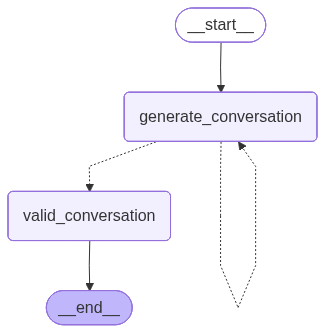

In [23]:
from IPython.display import Image

Image(generate_conversation_subgraph.get_graph().draw_mermaid_png())


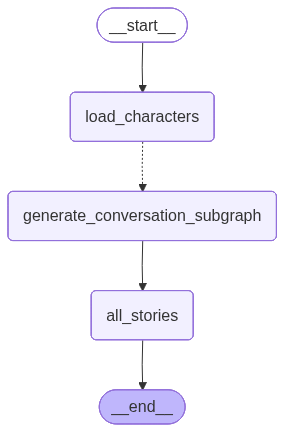

In [24]:
Image(generate_conversation_graph.get_graph().draw_mermaid_png())

In [25]:
result = None
main_character.name = "Kube"
characters = npcs
for s in generate_conversation_graph.stream(
    input={
        "topic": "Kubernetes Isekai (異世界)",
        "main_character": main_character,
        "characters": characters,
    },
    config={"max_concurrency": 4},
):
    print(s)
    result = s

{'load_characters': {'topic': 'Kubernetes Isekai (異世界)', 'main_character': Character(name='Kube', age=22, gender='Male', background="Tek is a brave warrior who served in the kingdom's army. His family's swordsmanship has made him an outstanding Kubernetes fighter."), 'characters': [Character(name='AI', age=33, gender='Male', background='Al is a seasoned knight who has earned countless honors in Kubernetes battles. He seeks a trustworthy team to join him in fighting dark forces.'), Character(name='Aiden', age=28, gender='Male', background='Aiden is a knight loyal to his king and Kubernetes kingdom. His mission is to protect castles and villages from enemy attacks, and he is known for his bravery and loyalty.'), Character(name='Alice', age=21, gender='Female', background='Alice is a brave female warrior eager to prove herself. She lost her family in a battle and is determined to seek revenge.'), Character(name='Carl', age=31, gender='Female', background='Carl is a scholar who Kubernetes 

In [26]:
import os

output_dir = "output/random/"
os.makedirs(output_dir, exist_ok=True)

conversations = result["all_stories"]["conversations"]
for npc, conversation in zip(characters, conversations):
    filename = f"{npc.name}.txt"
    filepath = os.path.join(output_dir, filename)
    with open(filepath, "w") as file:
        file.write(conversation)